In [1]:
import os
import time

import torch
import torchvision
import shutil
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.io import read_image, ImageReadMode

from PIL import Image, ImageDraw, ImageFont


## Paths and parameters

In [ ]:
images_root = '/media/eyildiz/data/zstack_analys/cnn_dataset/0.1_training_data'
train_csv = images_root + '/train_targets.csv'
val_csv = images_root + '/val_targets.csv'
test_csv = images_root+ '/test_targets.csv'

#model train parameters
base_path = './saved/best_model.pth'
learning_rate = 1e-4
batch_size = 64
total_epochs = 50


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing the Datasets

In [3]:
from enum import Enum
from typing import Optional, Union, List

class CacheStrategy(Enum):
    NO_CACHE = "no_cache"
    DISK_CACHE = "disk_cache"
    MEMORY_CACHE = "memory_cache"

class LoadDataset(Dataset):
    def __init__(
        self,
        path_csv: str,
        images_path: str,
        cache_strategy: Union[str, CacheStrategy] = CacheStrategy.MEMORY_CACHE,
        transforms: Optional[transforms.Compose] = None,
        img_size: int = 432,
        cache_dir: str = "cache"
    ):
        super().__init__()
        self.annots = pd.read_csv(path_csv)
        self.images_path = images_path
        self.transforms = transforms
        self.cache_dir = cache_dir
        self.img_size = img_size
        
        # Convert string to enum if necessary
        if isinstance(cache_strategy, str):
            cache_strategy = CacheStrategy(cache_strategy)
        self.cache_strategy = cache_strategy
        
        # Check for missing files
        self._check_missing_files(handle_missing='remove')
        
        # Initialize cache-related attributes
        self.cached_data = None
        self._setup_cache()
        
    def _setup_cache(self):
        """Set up caching based on the selected strategy"""
        if self.cache_strategy in [CacheStrategy.DISK_CACHE, CacheStrategy.MEMORY_CACHE]:
            if not os.path.exists(self.cache_dir):
                os.makedirs(self.cache_dir)
                
        if self.cache_strategy == CacheStrategy.MEMORY_CACHE:
            self.cached_data = self._load_or_cache()
    
    def _get_cache_path(self, index: int) -> str:
        """Get the cache file path for a given index"""
        return os.path.join(self.cache_dir, f"cached_{self.img_size}_{index}.pt")
    
    def _load_or_cache(self) -> List[torch.Tensor]:
        """Load all images into memory cache"""
        cached_data = []
        for i, img_path in enumerate(tqdm(self.annots.iloc[:, 0], desc='Caching Images to Memory')):
            cache_path = self._get_cache_path(i)
            
            if os.path.exists(cache_path):
                cached_data.append(torch.load(cache_path, weights_only=False))
            else:
                img = self._load_and_process_image(img_path)
                if self.cache_strategy != CacheStrategy.NO_CACHE:
                    torch.save(img, cache_path)
                cached_data.append(img)
                
        return cached_data
    
    def _load_and_process_image(self, img_path: str) -> torch.Tensor:
        """Load and process a single image"""
        img_path_full = os.path.join(self.images_path, img_path)
        try:
            img = Image.open(img_path_full)
            img = transforms.functional.resize(img, self.img_size, interpolation=transforms.InterpolationMode.BICUBIC)
            return img
        except FileNotFoundError:
            print(f"Image not found at path: {img_path_full}")
            raise
    
    def _get_image(self, index: int) -> torch.Tensor:
        """Get image based on caching strategy"""
        if self.cache_strategy == CacheStrategy.MEMORY_CACHE:
            return self.cached_data[index]
        
        elif self.cache_strategy == CacheStrategy.DISK_CACHE:
            cache_path = self._get_cache_path(index)
            if os.path.exists(cache_path):
                return torch.load(cache_path, weights_only=False)
            else:
                img = self._load_and_process_image(self.annots.iloc[index, 0])
                torch.save(img, cache_path)
                return img
                
        else:  # NO_CACHE
            return self._load_and_process_image(self.annots.iloc[index, 0])
    
    def __len__(self) -> int:
        return len(self.annots)
    
    def __getitem__(self, index: int) -> tuple:
        img = self._get_image(index)
        target = torch.tensor(self.annots.iloc[index, 1], dtype=torch.float)
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, target
    
    def visualize(self, idx: int) -> None:
        """Visualize a single image with its target value"""
        img, target = self.__getitem__(idx)
        if isinstance(img, torch.Tensor):
            tensor_to_pil = transforms.ToPILImage()
            img = tensor_to_pil(img)
        draw = ImageDraw.Draw(img)
        text = f'Offset = {target.item():.3f}'
        font = ImageFont.load_default()
        draw.text((30, 20), text, font=font)
        return img
        
    
    def _check_missing_files(self, handle_missing: str = 'log') -> List[str]:
        """Check for missing image files and handle them based on the provided method"""
        missing_files = []
        
        for idx, row in self.annots.iterrows():
            img_path = row.iloc[0]
            full_path = os.path.join(self.images_path, img_path)
            if not os.path.exists(full_path):
                missing_files.append(full_path)
                print(f"Missing file: {full_path}")
        
        if handle_missing == 'remove' and missing_files:
            self.annots = self.annots[~self.annots.iloc[:, 0].isin([os.path.relpath(f, self.images_path) for f in missing_files])]
            self.annots.reset_index(drop=True, inplace=True)
            print(f"Removed {len(missing_files)} missing file entries from the dataset.")
        
        return missing_files

In [4]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode

# Batch size and device configuration

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        # Geometric augmentations with RandomChoice

        transforms.RandomAffine(
            degrees=(-10, 10),
            translate=(0.3, 0.1),
            fill=2,
            interpolation = InterpolationMode.BILINEAR
        ),

        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomVerticalFlip(p=0.2),
        
        # Color augmentations
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        
        # Conversion and normalization
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0331], std=[0.0228]),  # Calculated on this dataset
        transforms.RandomErasing(p = 0.2, scale = (0.01, 0.03))
    ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0331], std=[0.0228]),  # Calculated on this dataset
    ]),
}


In [5]:
# Load the dataset with specified transformations


trainset = LoadDataset(
    train_csv,
    images_root,
    transforms=data_transforms['train'],
    cache_dir="cache_train"
)

valset = LoadDataset(
    test_csv,
    images_root,
    transforms=data_transforms['test'],
    cache_dir="cache_val"
)

Caching Images to Memory: 100%|██████████| 3212/3212 [00:24<00:00, 130.78it/s]


In [6]:
print('Image shapes: ', trainset[0][0].shape)

Image shapes:  torch.Size([1, 432, 512])


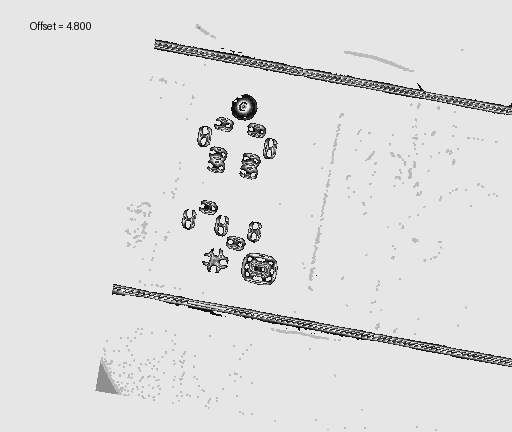

In [7]:
idx = torch.randint(0, len(trainset), size = (1, 1))
img = trainset.visualize(idx[0].item())
img

## Preparing Dataloaders

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)



                                     
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)




dataset_size = [len(trainset), len(valset)]



dataloaders= {
    "train": trainloader,
    "val": valloader
}

dataset_sizes = {
    "train": dataset_size[0],
    "val": dataset_size[1]
}

print('Size of datasets:', dataset_sizes)

Size of datasets: {'train': 28904, 'val': 3212}


## Model Architecture Defination
I will be using eficcientNetv2 small for intial testing and training of the data and developing network.

In [13]:
import torchvision
import torch.nn as nn


class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(
                out_channels,
                eps=0.001,
                momentum=0.1,
                affine=True,
                track_running_stats=True,
            ),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)


class ImageRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = self._init_feature_extractor()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()

        self.regression_head = nn.Sequential(
            nn.Dropout(0.45),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        features = self.feature_extractor(img)  # Output: [batch_size, 1280, H', W']
        features = self.avgpool(features)  # Output: [batch_size, 1280, 1, 1]
        features = self.flatten(features)  # Output: [batch_size, 1280]
        reg = self.regression_head(features)
        return reg

    def _init_feature_extractor(self, in_channels=1):
        base_network = torchvision.models.efficientnet_v2_s(weights=None)
        feature_extractor = base_network.features
        
        feature_extractor[0][0] = nn.Conv2d(
            1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        
        feature_extractor[0] = nn.Sequential(
            feature_extractor[0],
            Conv2dNormActivation(24, 24),
        )

        feature_extractor = nn.Sequential(
            feature_extractor[:2],
            feature_extractor[2][:2],
            feature_extractor[3][:2],
            feature_extractor[4][:3],
            feature_extractor[5][:2],
            feature_extractor[6][:4],
            feature_extractor[-1],
        )
        # ref:https://www.researchgate.net/figure/Efficientnet-v2-s-Architecture-a-represents-the-schematic-of-the-model-from-image-input_fig2_373782480
        # There are total 8 blocks, 2 conv3dNorm(at start and at end) and 3 fused mbconv , 3 mb conv
        return feature_extractor


In [14]:
model = ImageRegressor()

#test
inp = torch.randn((1, 1, 270, 320))

out = model(inp)
out.shape



torch.Size([1, 1])

## Training the Model

### Helper Functions for training and Evaluation

In [15]:
os.makedirs('saved_models', exist_ok = True)

In [16]:
import torch
import torch.nn as nn
import time
import os
import shutil
from tqdm import tqdm
from typing import Dict, Any, Optional

def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    dataloaders: Dict[str, torch.utils.data.DataLoader],
    dataset_sizes: Dict[str, int],
    device: torch.device,
    num_epochs: int = 25,
    metric: nn.Module = nn.L1Loss(reduction='mean'),
    patience: int = 12,
    min_delta: float = 1e-4
) -> tuple[nn.Module, Dict[str, Any]]:
    """
    Train a PyTorch model with forward and backward propagation.
    
    Args:
        model: PyTorch model to train
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary containing size of 'train' and 'val' datasets
        device: Device to train on (cuda/cpu)
        num_epochs: Maximum number of epochs to train
        metric: Metric to track for model performance (default: MAE)
        patience: Number of epochs to wait before early stopping
        min_delta: Minimum change in monitored value to qualify as an improvement
        
    Returns:
        tuple: (best_model, training_history)
    """
    since = time.time()
    
    # Initialize epoch data storage
    epoch_data = {
        'epoch': [],
        'train': {'loss': [], 'MAE': []},
        'val': {'loss': [], 'MAE': []}
    }
    
    # Create temporary directory for model checkpoints
    tempdir = './temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
    # Save initial model state
    torch.save(model.state_dict(), best_model_params_path)
    
    best_mae = float('inf')
    no_improve_epochs = 0
    
    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            epoch_data['epoch'].append(epoch+1)
            
            # Training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_mae = 0.0
                
                # Iterate over data
                for inputs, targets in tqdm(dataloaders[phase], desc=f'{phase} phase'):
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    targets = targets.view(-1, 1)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    batch_size = inputs.size(0)
                    running_loss += loss.item() * batch_size
                    running_mae += metric(outputs, targets).item() * batch_size
                
                if phase == 'train':
                    scheduler.step()
                
                # Calculate epoch metrics
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_mae = running_mae / dataset_sizes[phase]
                
                # Store metrics
                epoch_data[phase]['loss'].append(epoch_loss)
                epoch_data[phase]['MAE'].append(epoch_mae)
                
                print(f'{phase} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')
                
                # Save best model
                if phase == 'val':
                    if epoch_mae < best_mae - min_delta:
                        best_mae = epoch_mae
                        torch.save(model.state_dict(), best_model_params_path)
                        no_improve_epochs = 0
                    else:
                        no_improve_epochs += 1

                    if  epoch%10 == 0:
                        torch.save(model.state_dict(), f'saved_models/checkpoint_mae_{epoch_mae:.4f}_epoch_{epoch}.pth')
                        
            
            print()
            
            # Early stopping check
            if no_improve_epochs >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break


                
                
    except KeyboardInterrupt:
        print('Training interrupted by user')
    
    finally:
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val MAE: {best_mae:4f}')
        
        # Load best model
        model.load_state_dict(torch.load(best_model_params_path, weights_only = True))
        
        # Clean up temporary directory
        shutil.rmtree(tempdir)
    
    return model, best_mae, epoch,  epoch_data, 

In [17]:
def evaluate_model(model, criterion , dataloader):
    model.eval()
    metric = nn.L1Loss()
    running_loss = 0.0
    running_mae = 0

    for inputs, targets in tqdm(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.view(-1, 1) 
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            running_mae += metric(outputs, targets).item()*inputs.size(0)

    eval_loss = running_loss / len(dataloader.dataset)
    eval_mae = running_mae / len(dataloader.dataset)

    print(f'Evaluation Loss: {eval_loss:.4f} Evaluation MAE: {eval_mae:.4f}')

    return eval_loss, eval_mae

In [18]:
class CustomLoss(nn.Module):
    def __init__(self, ratio = 0.5):
        super().__init__()
        self.ratio = ratio
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

    def forward(self, pred, targets):
        l1 = self.mse(pred, targets)
        l2 = self.mae(pred, targets)
        return self.ratio*l1 + (1-self.ratio)*l2

### Training the model 

In [19]:
## 
from torch import optim

model = ImageRegressor()
model = model.to(device)
model.load_state_dict(torch.load(base_path))
criterion = CustomLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=learning_rate)


exp_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=[30], gamma=0.1)


model, best_mae, epoch, history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,device, num_epochs = total_epochs, patience=20)


<ipython-input-19-322ad63e0cc4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/imagereg/pytorch/default/1/image_regressor_w

Epoch 1/50
----------


train phase: 100%|██████████| 452/452 [04:30<00:00,  1.67it/s]


train Loss: 0.8088 MAE: 0.6366


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.52it/s]


val Loss: 0.3245 MAE: 0.3992

Epoch 2/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.3683 MAE: 0.4332


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.71it/s]


val Loss: 0.2961 MAE: 0.3780

Epoch 3/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.3411 MAE: 0.4118


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.02it/s]


val Loss: 0.2811 MAE: 0.3610

Epoch 4/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.3209 MAE: 0.3956


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]


val Loss: 0.2688 MAE: 0.3511

Epoch 5/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.3135 MAE: 0.3902


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]


val Loss: 0.2532 MAE: 0.3363

Epoch 6/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.3083 MAE: 0.3858


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]


val Loss: 0.2650 MAE: 0.3488

Epoch 7/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2982 MAE: 0.3754


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.2394 MAE: 0.3249

Epoch 8/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.2902 MAE: 0.3693


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.07it/s]


val Loss: 0.2401 MAE: 0.3226

Epoch 9/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2881 MAE: 0.3674


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.84it/s]


val Loss: 0.2316 MAE: 0.3164

Epoch 10/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2836 MAE: 0.3635


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.98it/s]


val Loss: 0.2346 MAE: 0.3182

Epoch 11/50
----------


train phase: 100%|██████████| 452/452 [04:30<00:00,  1.67it/s]


train Loss: 0.2811 MAE: 0.3600


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]


val Loss: 0.2292 MAE: 0.3151

Epoch 12/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2756 MAE: 0.3561


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.83it/s]


val Loss: 0.2385 MAE: 0.3229

Epoch 13/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2749 MAE: 0.3551


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.07it/s]


val Loss: 0.2239 MAE: 0.3086

Epoch 14/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.2725 MAE: 0.3528


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.06it/s]


val Loss: 0.2166 MAE: 0.3003

Epoch 15/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2737 MAE: 0.3538


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.91it/s]


val Loss: 0.2263 MAE: 0.3090

Epoch 16/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2693 MAE: 0.3491


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.95it/s]


val Loss: 0.2186 MAE: 0.3001

Epoch 17/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2624 MAE: 0.3429


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.90it/s]


val Loss: 0.2145 MAE: 0.2970

Epoch 18/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2652 MAE: 0.3455


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]


val Loss: 0.2147 MAE: 0.2948

Epoch 19/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2647 MAE: 0.3446


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.07it/s]


val Loss: 0.2116 MAE: 0.2943

Epoch 20/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.2596 MAE: 0.3405


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.96it/s]


val Loss: 0.2186 MAE: 0.3000

Epoch 21/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2598 MAE: 0.3398


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.99it/s]


val Loss: 0.2113 MAE: 0.2956

Epoch 22/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2555 MAE: 0.3364


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.2035 MAE: 0.2867

Epoch 23/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2575 MAE: 0.3381


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.72it/s]


val Loss: 0.1993 MAE: 0.2808

Epoch 24/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2543 MAE: 0.3345


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.93it/s]


val Loss: 0.2228 MAE: 0.3040

Epoch 25/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.2526 MAE: 0.3332


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.03it/s]


val Loss: 0.2052 MAE: 0.2883

Epoch 26/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2515 MAE: 0.3319


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.82it/s]


val Loss: 0.2000 MAE: 0.2823

Epoch 27/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2495 MAE: 0.3298


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.02it/s]


val Loss: 0.1897 MAE: 0.2706

Epoch 28/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2470 MAE: 0.3281


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.00it/s]


val Loss: 0.2024 MAE: 0.2845

Epoch 29/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2471 MAE: 0.3274


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.87it/s]


val Loss: 0.1944 MAE: 0.2757

Epoch 30/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.69it/s]


train Loss: 0.2422 MAE: 0.3230


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.1951 MAE: 0.2771

Epoch 31/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2415 MAE: 0.3222


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.90it/s]


val Loss: 0.1920 MAE: 0.2739

Epoch 32/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2391 MAE: 0.3201


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.95it/s]


val Loss: 0.1936 MAE: 0.2758

Epoch 33/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2379 MAE: 0.3187


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]


val Loss: 0.1940 MAE: 0.2758

Epoch 34/50
----------


train phase: 100%|██████████| 452/452 [04:27<00:00,  1.69it/s]


train Loss: 0.2377 MAE: 0.3184


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.90it/s]


val Loss: 0.1946 MAE: 0.2768

Epoch 35/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2371 MAE: 0.3182


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.1940 MAE: 0.2755

Epoch 36/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2361 MAE: 0.3167


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.11it/s]


val Loss: 0.1934 MAE: 0.2748

Epoch 37/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2356 MAE: 0.3162


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.86it/s]


val Loss: 0.1914 MAE: 0.2731

Epoch 38/50
----------


train phase: 100%|██████████| 452/452 [04:30<00:00,  1.67it/s]


train Loss: 0.2376 MAE: 0.3184


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.1916 MAE: 0.2734

Epoch 39/50
----------


train phase: 100%|██████████| 452/452 [04:31<00:00,  1.67it/s]


train Loss: 0.2356 MAE: 0.3165


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.05it/s]


val Loss: 0.1937 MAE: 0.2752

Epoch 40/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2352 MAE: 0.3152


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.87it/s]


val Loss: 0.1956 MAE: 0.2770

Epoch 41/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2356 MAE: 0.3163


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.07it/s]


val Loss: 0.1896 MAE: 0.2709

Epoch 42/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2350 MAE: 0.3158


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]


val Loss: 0.1908 MAE: 0.2721

Epoch 43/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2355 MAE: 0.3164


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.02it/s]


val Loss: 0.1936 MAE: 0.2749

Epoch 44/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.68it/s]


train Loss: 0.2344 MAE: 0.3149


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


val Loss: 0.1889 MAE: 0.2701

Epoch 45/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.67it/s]


train Loss: 0.2350 MAE: 0.3158


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.05it/s]


val Loss: 0.1903 MAE: 0.2716

Epoch 46/50
----------


train phase: 100%|██████████| 452/452 [04:28<00:00,  1.68it/s]


train Loss: 0.2340 MAE: 0.3148


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


val Loss: 0.1872 MAE: 0.2686

Epoch 47/50
----------


train phase: 100%|██████████| 452/452 [04:30<00:00,  1.67it/s]


train Loss: 0.2343 MAE: 0.3151


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.98it/s]


val Loss: 0.1903 MAE: 0.2722

Epoch 48/50
----------


train phase: 100%|██████████| 452/452 [04:30<00:00,  1.67it/s]


train Loss: 0.2339 MAE: 0.3147


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.06it/s]


val Loss: 0.1873 MAE: 0.2683

Epoch 49/50
----------


train phase: 100%|██████████| 452/452 [04:29<00:00,  1.67it/s]


train Loss: 0.2328 MAE: 0.3139


val phase: 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]


val Loss: 0.1883 MAE: 0.2695

Epoch 50/50
----------


train phase: 100%|██████████| 452/452 [04:31<00:00,  1.67it/s]


train Loss: 0.2344 MAE: 0.3151


val phase: 100%|██████████| 51/51 [00:06<00:00,  7.81it/s]


val Loss: 0.1923 MAE: 0.2742

Training complete in 229m 24s
Best val MAE: 0.268289


## Plotting the History

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plots training and validation loss and MAE over epochs from the given data structure.

    Parameters:
        history (dict): A dictionary containing training and validation metrics per epoch.
    """
    epochs = history['epoch']

    # Extract metrics
    train_loss = history['train']['loss']
    train_mae = history['train']['MAE']
    val_loss = history['val']['loss']
    val_mae = history['val']['MAE']

    # Create subplots for Loss and MAE
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Loss
    axs[0].plot(epochs, train_loss, label='Train Loss', marker='o', color='blue')
    axs[0].plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot MAE
    axs[1].plot(epochs, train_mae, label='Train MAE', marker='o', color='green')
    axs[1].plot(epochs, val_mae, label='Validation MAE', marker='o', color='red')
    axs[1].set_title('MAE vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

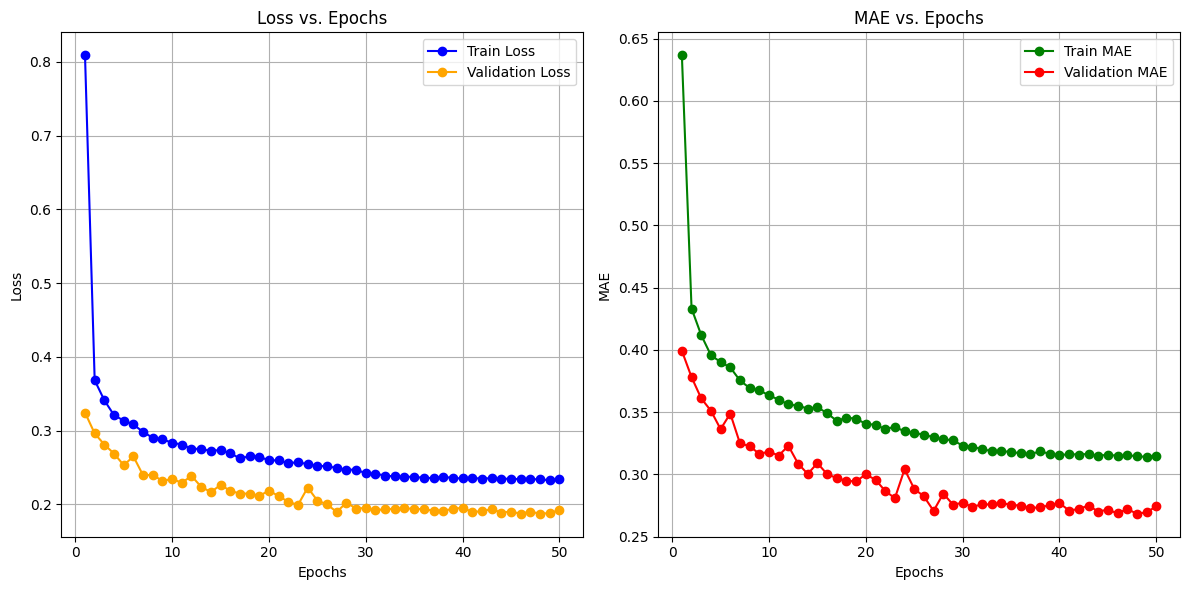

In [22]:
plot_history(history)

## Saving the best model

In [23]:
import pickle
os.makedirs('saved_models', exist_ok = True)
torch.save(model, f'saved_models/image_regressor_mae_{best_mae}_epoch_{epoch}.pth')
torch.save(model.state_dict(), f'saved_models/image_regressor_wts_mae_{best_mae:.4f}_epoch_{epoch}.pth')

with open('saved_models/train_history.pkl', 'wb') as f:
    pickle.dump(history, f)

## Evaluating on the Testset

In [24]:


testset = LoadDataset(
    test_csv,
    images_root,
    transforms=data_transforms['test'],
    cache_strategy = CacheStrategy.NO_CACHE
)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

print('Testset Size: ', len(testset), 'images')

Testset Size:  1010 images


In [25]:
eval_loss, eval_mae = evaluate_model(model, criterion , testloader)

100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Evaluation Loss: 0.1684 Evaluation MAE: 0.2350
